In [4]:
%load_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
import geopandas as gpd
import xgboost
import sys
from sklearn.preprocessing import LabelEncoder
import numpy as np
from math import * 
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN, OPTICS
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.style.use('dark_background')

from utils import plot_cluster, load_list, save_list, load_data, load_data_test


In [18]:
X, Y = load_data(add_knn_mean=True,
                 add_knn_concat=True,
                 add_polynomial=True,
                 add_dates=True,
                 add_fourier=True,
                 add_capitals=True,
                 add_countries=True,
                 n_data_max=9999999999,
                 shuffle = True)

X_target = load_data_test(add_knn_mean=True,
                 add_knn_concat=True,
                 add_polynomial=True,
                 add_dates=True,
                 add_fourier=True,
                 add_capitals=True,
                 add_countries=True,
                 n_data_max=99999999,
                 shuffle = False)

print(f'Datas containing NA loaded: {len(X[X.isna().any(axis = 1)])}')


Loading data...


c:\Users\maxwo\projets\MLcompetition\utils.py:66: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = train_df.drop("change_type", 1)



Basic features lenght: 310006
knn mean features lenght: 310006
knn concat features lenght: 310006
Dates features lenght: 310006
Building Fourier coefficients...
Done
Distances to nearest capitals...
Done
Adding countries...
Done
X_train and Y_train loaded.
Loading data...

Basic features lenght: 121704
knn mean features lenght: 121704
knn concat features lenght: 121704
Dates features lenght: 121704
Building Fourier coefficients...
Done
Distances to nearest capitals...
Done
Adding countries...
Done
X_val loaded.
Datas containing NA loaded: 1822


In [4]:
X.head()

,1_Construction Done,1_Construction Midway,1_Construction Started,1_Excavation,1_Greenland,1_Land Cleared,1_Materials Dumped,1_NA,1_Operational,1_Prior Construction,...,Mexico,Palestine,Qatar,Saudi Arabia,South Africa,Sweden,Tanzania,United Arab Emirates,United States of America,Vietnam
2077,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181633,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160540,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237087,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21303,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(X.shape)
print(Y.shape)
print(X_target.shape)

(310006, 275)
(310006,)
(121704, 275)


In [20]:
print(list(X_target.columns))

['1_Construction Done', '1_Construction Midway', '1_Construction Started', '1_Excavation', '1_Greenland', '1_Land Cleared', '1_Materials Dumped', '1_NA', '1_Operational', '1_Prior Construction', '2_Construction Done', '2_Construction Midway', '2_Construction Started', '2_Excavation', '2_Greenland', '2_Land Cleared', '2_Materials Dumped', '2_NA', '2_Operational', '2_Prior Construction', '3_Construction Done', '3_Construction Midway', '3_Construction Started', '3_Excavation', '3_Greenland', '3_Land Cleared', '3_Materials Dumped', '3_NA', '3_Operational', '3_Prior Construction', '4_Construction Done', '4_Construction Midway', '4_Construction Started', '4_Excavation', '4_Greenland', '4_Land Cleared', '4_Materials Dumped', '4_NA', '4_Operational', '4_Prior Construction', '5_Construction Done', '5_Construction Midway', '5_Construction Started', '5_Excavation', '5_Greenland', '5_Land Cleared', '5_Materials Dumped', '5_NA', '5_Operational', '5_Prior Construction', 'diff1', 'diff2', 'diff3', 'd

In [14]:
print([x for x in X.columns if not x in X_target.columns])
print([x for x in X_target.columns if not x in X.columns])

[]
[]


Fitting...


C:\Users\maxwo\anaconda3\envs\py38gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train score: 0.8577707120666748
Test score: 0.8577619630686116



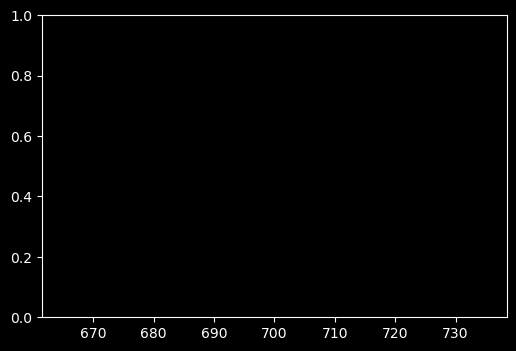

In [21]:

# xgb = XGBClassifier()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)
# X=X.values
# Y=Y.values 
# X_target=X_target.values
print('Fitting...')

average = 'weighted'
L_train_score = list()
L_test_score = list()
L = list()
def xgb_f1(y, t):
    y_true = t.get_label()
    y = np.array([np.argmax(y[i]) for i in range(len(y))])
    res = 1 - f1_score(y_true, y, average="micro")
    print(res)
    return "f1", res
    
# n_splits = 5
# folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=32)
# xgb_clf = XGBClassifier( 
#         objective= 'multi:softprob',
#         max_depth=6,           # maximum depth of each tree - try 2 to 10
#         learning_rate=0.1,    # effect of each tree - try 0.0001 to 0.1. MEilleur valeur 0.3
#         n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000 Meilleur valeur 320
#         gamma=1.2, 
#         min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#         colsample_bytree=0.56,  # fraction of features (columns) per tree - try 0.2 to 1.0
#         subsample=0.8,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#         reg_alpha=4,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#         reg_lambda=5.5)        # L2 regularization (like Ridge) - try 0.0 to 10.0)
# val = np.zeros(X.shape[0])
# pred_mat = np.zeros((X_target.shape[0], n_splits))
# for fold_index, (train_index, val_index) in enumerate(folds.split(X, Y)):
#     print('Batch {} started...'.format(fold_index))
#     eval_metric=['error']
#     bst = xgb_clf.fit(X[train_index], Y[train_index],
#                       eval_metric=eval_metric
#                       )
#     val[val_index] = xgb_clf.predict(X[val_index])
#     print('f1_score of this val set is {}'.format(
#         f1_score(Y[val_index], val[val_index], average='micro')))
#     pred_mat[:, fold_index] = xgb_clf.predict(X_target)


# model = RandomForestClassifier(n_estimators=n,
#                     max_depth=15,
#                     min_samples_leaf=1,
#                     min_samples_split=2,
#                         )
# model = GradientBoostingClassifier(n_estimators=n, 
#                         )
model = XGBClassifier( 
                objective= 'multi:softprob',
max_depth=6,           # maximum depth of each tree - try 2 to 10
learning_rate=0.1,    # effect of each tree - try 0.0001 to 0.1. MEilleur valeur 0.3
n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000 Meilleur valeur 320
gamma=1.2, 
min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
colsample_bytree=0.56,  # fraction of features (columns) per tree - try 0.2 to 1.0
subsample=0.8,         # fraction of instances (rows) per tree - try 0.2 to 1.0
reg_alpha=4,         # L1 regularization (like LASSO) - try 0.0 to 10.0
reg_lambda=5.5,        # L2 regularization (like Ridge) - try 0.0 to 10.0
tree_method='gpu_hist', gpu_id=0)


eval_set = [(X_train, Y_train), (X_test, Y_test)]
eval_metric = ['error']   # better with error than xgb_f1 ??
model.fit(X,Y,    # train on the entire training set for final submits (to maximize the score)
        eval_metric=eval_metric, 
        # eval_set=eval_set, 
        # verbose=False
          )

Y_pred          = model.predict(X_test)
Y_pred_train    = model.predict(X_train)
score_train = f1_score(Y_train, Y_pred_train, average = average)
score_test = f1_score(Y_test, Y_pred, average = average)
L_train_score.append(score_train)
L_test_score.append(score_test)
print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

model_final = model



In [ ]:


def most_common(lst):
    return max(set(lst), key=lst.count)


pred = np.zeros(X_target.shape[0])
for i in range(X_target.shape[0]):
    pred[i] = most_common(list(pred_mat[i, :]))

from copy import deepcopy
def compress_outliers_on_test(X):
    '''Replace outliers geographically data points of test (plot test data to see what it means) to an area where they could be i guess.
    '''
    X_ = deepcopy(X)
    X_[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30
    return X_

X_target = compress_outliers_on_test(X_target)
Y_pred2submit = xgb_clf.predict(X_target)
# Save results to submission file
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission.csv", index=True, index_label='Id')


In [11]:
#IMPORTANCES OF FEATURES
importances = model.feature_importances_
for feature, imp in sorted(zip(X_train.columns, importances), key = lambda x: -x[1]):
    print(f'Importance of {feature}: {100*round(imp, 3)}%')

Importance of change_status_date5: 17.399999499320984%
Importance of change_status_date1: 5.499999970197678%
Importance of knn_mean_length/width: 2.500000037252903%
Importance of change_status_date2: 1.899999938905239%
Importance of area/length**2: 1.7000000923871994%
Importance of centroid_y: 1.600000075995922%
Importance of harm1_coeff1: 1.600000075995922%
Importance of knn_mean_area: 1.0999999940395355%
Importance of duration_to_reach5: 0.9999999776482582%
Importance of knn_mean_Desert: 0.9999999776482582%
Importance of knn_mean_area/length**2: 0.9999999776482582%
Importance of knn_mean_centroid_x: 0.9999999776482582%
Importance of centroid_dist: 0.8999999612569809%
Importance of old2: 0.8999999612569809%
Importance of 1th_nn_year_date4: 0.8999999612569809%
Importance of nb_points: 0.8999999612569809%
Importance of 1th_nn_centroid_x: 0.8999999612569809%
Importance of diff4: 0.8999999612569809%
Importance of height: 0.8999999612569809%
Importance of knn_mean_Industrial: 0.80000003799

In [ ]:
#FEATURE SELECTION USING CROSS VAL (too long)
from sklearn.feature_selection import RFECV
xgboost.set_config(verbosity=0)
xgb = model = XGBClassifier( 
                        n_estimators = 2,
                #       scale_pos_weight=1,
                #       learning_rate=0.01,  
                #       colsample_bytree = 0.4,
                #       subsample = 0.8,
                #       objective='binary:logistic', 
                #       reg_alpha = 0.3,
                        max_depth=2, 
                #       gamma=10,
                        use_label_encoder=False,
                      )
scorer = lambda estimator, x_test, y_true : f1_score(y_true, estimator.predict(x_test), average = 'weighted')
xgb_fs = RFECV(xgb, cv = 3, scoring = scorer)
N = 10000     
xgb_fs.fit(X_train[:N], np.array(Y_train[:N]))

In [418]:
K = 10
importances = np.zeros(shape = (X.shape[1], K))
for k in range(K):
        xgb = model = XGBClassifier( 
                        n_estimators = 10,
                        max_depth=5, 
                        use_label_encoder=False,
                      )
        X_fold = X[k*len(X)//K: (k+1)*len(X)//K]
        Y_fold = Y[k*len(X)//K: (k+1)*len(X)//K]
        print('fit on data:', len(X_fold))
        xgb.fit(X_fold, Y_fold)
        importances[:, k] = xgb.feature_importances_

for feature, imp in sorted(zip(X_train.columns, importances), key = lambda x: -x[1].mean()):
        print(f'Importance of {feature}: {100*round(imp.mean(), 3)} +/- {100*round(imp.std(), 3)}')

fit on data: 31000
fit on data: 31001
fit on data: 31000
fit on data: 31001
fit on data: 31001
fit on data: 31000
fit on data: 31001
fit on data: 31000
fit on data: 31001
fit on data: 31001
Importance of knn_mean_length/width: 13.4 +/- 2.7
Importance of change_status_date5: 9.5 +/- 0.8
Importance of change_status_date1: 5.5 +/- 0.3
Importance of knn_mean_area/length**2: 5.0 +/- 2.4
Importance of area/length**2: 4.9 +/- 0.7000000000000001
Importance of centroid_dist: 3.5000000000000004 +/- 1.0999999999999999
Importance of knn_mean_area: 3.1 +/- 0.4
Importance of knn_mean_Industrial: 2.7 +/- 0.8
Importance of length: 2.7 +/- 1.4000000000000001
Importance of knn_mean_centroid_x: 2.6 +/- 3.5000000000000004
Importance of change_status_date2: 2.6 +/- 0.6
Importance of elongation: 2.3 +/- 0.8
Importance of centroid_y: 2.1999999999999997 +/- 0.4
Importance of height: 2.0 +/- 0.3
Importance of duration_to_reach5: 1.7000000000000002 +/- 0.4
Importance of old2: 1.7000000000000002 +/- 0.2
Importan

In [399]:
N = 1000
Y_train[:N][Y_train[:N] == 4]

216751    4
Name: change_type, dtype: int64

In [406]:
features = list(X.columns)
selected_features = np.array(features)[xgb_fs.get_support()]
print(len(features))
print(selected_features)

129
['change_status_date5' 'area/length**2' 'centroid_y' 'height'
 'knn_mean_area/length**2' 'knn_mean_length/width' 'duration_to_reach5']


In [22]:
from copy import deepcopy
def compress_outliers_on_test(X):
    '''Replace outliers geographically data points of test (plot test data to see what it means) to an area where they could be i guess.
    '''
    X_ = deepcopy(X)
    X_[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30
    return X_
    
def sabotage(Y, frac = .5):
    N = int(frac * len(Y))
    Y[:N] = 5
    return Y

In [23]:
X_target = compress_outliers_on_test(X_target)
Y_pred2submit = model.predict(X_target)
# Save results to submission file
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission.csv", index=True, index_label='Id')

C:\Users\maxwo\AppData\Local\Temp/ipykernel_18060/677289814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30


In [14]:
Y_pred2submit.shape

(121704,)

In [14]:
Y_pred2submit = sabotage(Y_pred2submit, frac = 0.08)
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission2.csv", index=True, index_label='Id')

NameError: name 'Y_pred2submit' is not defined

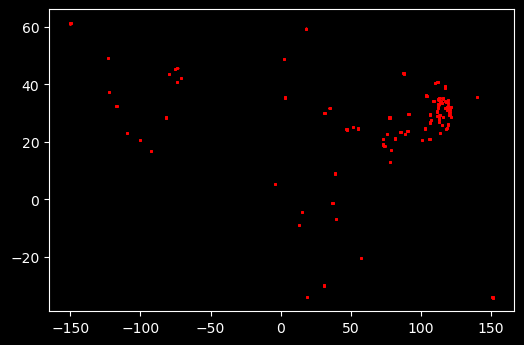

In [16]:
plot_cluster(X)